In [68]:
from keras.models import Sequential
from tensorflow.keras.layers import *
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 
import librosa

In [3]:
ravdess="Audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
ravdess_directory_list.remove('.DS_Store')

In [4]:
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + dir + '/' + file)   

In [5]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

In [6]:
path_df = pd.DataFrame(file_path, columns=['Path'])

In [7]:
# concating and adding label names
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [8]:
# Removing suprise emotions since very few audio files available
ravdess_df = ravdess_df[ravdess_df.Emotions != 'calm']

In [9]:
# read the second dataset; TORONTO EMOTION SPEECH SET
TESS="TESS Toronto emotional speech set data/"
TESS_directory_list = os.listdir(TESS)
TESS_directory_list.remove('.DS_Store')

In [54]:
#TESS_directory_list

In [11]:
TESS_emotion = []
TESS_path = []

for dir in TESS_directory_list:
    actor = os.listdir(TESS + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('_')
        TESS_emotion.append(part[2])
        TESS_path.append(TESS + dir + '/' + file)

In [12]:
tess_emotion_df = pd.DataFrame(TESS_emotion, columns=['Emotions'])

In [13]:
tess_path_df = pd.DataFrame(TESS_path, columns=['Path'])

In [14]:
tess_df = pd.concat([tess_emotion_df, tess_path_df], axis=1)

In [15]:
# change ps to surprise to match the label
tess_df['Emotions'].replace('ps','surprise',inplace=True)

In [16]:
#reading third dataset;  CREMA-D dataset
crema_path="AudioWAV/"
crema_directory_list = os.listdir(crema_path)


file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(crema_path + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)


In [17]:
# combining all the datasets
df_merged = pd.concat([tess_df, ravdess_df,crema_df], ignore_index=True, sort=False)

In [18]:
# Removing suprise emotions since very few audio files available
df_merged = df_merged[df_merged.Emotions != 'surprise']

In [19]:
df_merged.Emotions.value_counts()

Emotions
disgust    1863
happy      1863
sad        1863
fear       1863
angry      1863
neutral    1583
Name: count, dtype: int64

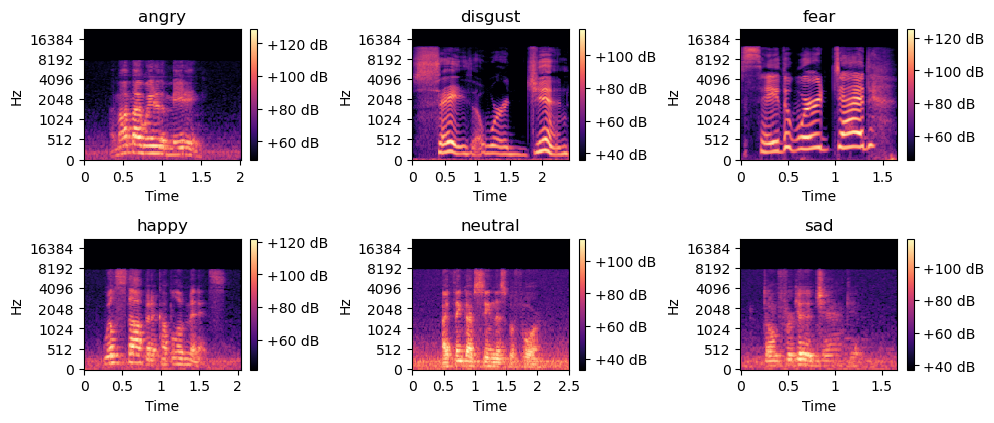

In [20]:
#extracting sample emotions of each kind
#one can think of a spectrogram as a bunch of FFTs stacked on top of each other. 
#It is a way to visually represent a signal’s loudness, or amplitude, as it varies over time at different frequencies. 

sample = df_merged.groupby('Emotions', group_keys=False).apply(lambda x: x.sample(1))
# extracting the paths from the sample
sample_paths = sample['Path'].tolist()
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(3, 3, i+1)
    signal, sr = librosa.load(sample_paths[i], sr=44100)     # Loading the audio file
    signal = librosa.feature.melspectrogram(y = signal, sr=sr)
    signal = librosa.power_to_db(signal, ref=np.min)
    librosa.display.specshow(signal, sr=sr, x_axis='time', y_axis='mel')     # Plotting the spectrogram
    plt.title(sample['Emotions'].values[i])
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

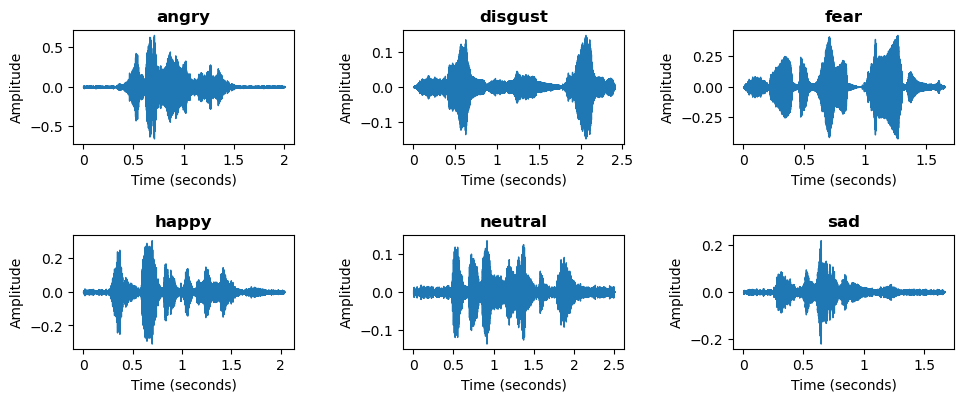

In [21]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3, 3, i+1)
    data, sr = librosa.load(sample_paths[i], sr = 44100)
    librosa.display.waveshow(data, sr=sr)
    plt.title(sample['Emotions'].values[i], fontweight='bold')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
plt.tight_layout(pad=2)

In [22]:
df_merged

,Emotions,Path
0,disgust,TESS Toronto emotional speech set data/YAF_dis...
1,disgust,TESS Toronto emotional speech set data/YAF_dis...
2,disgust,TESS Toronto emotional speech set data/YAF_dis...
3,disgust,TESS Toronto emotional speech set data/YAF_dis...
4,disgust,TESS Toronto emotional speech set data/YAF_dis...
...,...,...
11485,angry,AudioWAV/1089_WSI_ANG_XX.wav
11486,angry,AudioWAV/1025_IWW_ANG_XX.wav
11487,angry,AudioWAV/1030_IWW_ANG_XX.wav
11488,angry,AudioWAV/1019_TIE_ANG_XX.wav


In [23]:
import IPython.display as ipd
ipd.Audio(df_merged['Path'][1005])

In [24]:
#feature extraction
x, sr = librosa.load(df_merged['Path'][1005])
ipd.Audio(x, rate=sr)

In [55]:


mel_spectrograms = []
zcr_list = []
mfcc_list = []
rms_list = []
labels = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
MAX_LEN = 130  # target length for padding

# Iterating over each row in the DataFrame s
for index, row in df_merged.iterrows():
    y, sr = librosa.load(row['Path'], sr=None)

    # Mel Spectrogram
    #A mel spectrogram shows how the frequency content of the signal changes over time.
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram)  
    mel_spectrogram_db = pad_sequences([mel_spectrogram_db.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Zero Crossing Rate
    # Zero Crossing Rate is the rate at which the signal changes from positive to negative or vice versa. It provides information about the frequency content of the signal.
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    zcr = pad_sequences([zcr.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Root Mean Square (RMS)
    # RMS Energy is a measure of the signal’s overall energy or loudness over time. It provides insight into the amplitude variations of the audio signal.

    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    rms = pad_sequences([rms.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # MFCC
    # provide a compact representation of the spectral envelope of a sound that closely relates to how humans perceive pitch and frequency content.
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    mfcc = pad_sequences([mfcc.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Adding features to respective lists
    mel_spectrograms.append(mel_spectrogram_db)
    zcr_list.append(zcr)
    rms_list.append(rms)
    mfcc_list.append(mfcc)
    labels.append(row['Emotions'])

In [56]:
X = np.concatenate([np.array(mel_spectrograms), np.array(zcr_list), np.array(rms_list), np.array(mfcc_list)], axis=-1)

In [57]:
X = X.astype('float32')

In [58]:
X.shape

(10898, 1, 130, 79)

In [59]:
y = np.asarray(labels)

In [60]:
#Encoding the emotion labels

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converting labels to integers
y_one_hot = to_categorical(y_encoded)

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_one_hot,random_state=102,test_size=0.2,shuffle=True)

In [62]:
X_train.shape

(8718, 1, 130, 79)

In [63]:
#standardising the data
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [64]:
#Reshaping the standardized data to give as input in the model
X_train = X_train.reshape(X_train.shape[0],130,79)
X_test = X_test.reshape(X_test.shape[0],130,79)

In [65]:
X_train.shape

(8718, 130, 79)

In [66]:
# Defining/Compiling the model architecture



model=Sequential([
    Conv2D(32,kernel_size=3,activation='relu',input_shape=(130,79,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64,kernel_size=3,activation='relu',input_shape=(130,79,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/Users/vidhipitroda/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 128, 77, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 38, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 30, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 15, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 15, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 7, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 3, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 3, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,998 (1.22 MB)

 Trainable params: 320,998 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.fit(X_train,y_train,validation_split=0.2,epochs=40,batch_size=32)

Epoch 1/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.2363 - loss: 1.7124 - val_accuracy: 0.3744 - val_loss: 1.5002
Epoch 2/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.3760 - loss: 1.4883 - val_accuracy: 0.4306 - val_loss: 1.3854
Epoch 3/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.4445 - loss: 1.3652 - val_accuracy: 0.5247 - val_loss: 1.1666
Epoch 4/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.5138 - loss: 1.2114 - val_accuracy: 0.5390 - val_loss: 1.1253
Epoch 5/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.5458 - loss: 1.1421 - val_accuracy: 0.5413 - val_loss: 1.1048
Epoch 6/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.5621 - loss: 1.0884 - val_accuracy: 0.5264 - val_loss: 1.1533
Epoch 7/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.5731 - loss: 1.0657 - val_accuracy: 0.5700 - val_loss: 1.0456
Epoch 8/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.6075 - loss: 1.0072 - 

In [51]:

loss, accuracy = model.evaluate(X_test,y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {100*accuracy:.2f}%')

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6558 - loss: 1.2153
Test Loss: 1.2189
Test Accuracy: 66.24%


In [52]:
# Predicting on test data
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)  

# Decoding classes indices back to emotions
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

# Checking for random predictions
df_pred = pd.DataFrame({
    'Predicted Labels': y_pred_labels,
    'Actual Labels': y_test_labels
})

df_pred.iloc[140:145]

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


,Predicted Labels,Actual Labels
140,disgust,disgust
141,sad,neutral
142,angry,neutral
143,angry,angry
144,disgust,sad


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

       angry       0.78      0.74      0.76       408
     disgust       0.72      0.59      0.65       364
        fear       0.68      0.52      0.59       362
       happy       0.56      0.62      0.59       360
     neutral       0.69      0.75      0.72       312
         sad       0.59      0.74      0.66       374

    accuracy                           0.66      2180
   macro avg       0.67      0.66      0.66      2180
weighted avg       0.67      0.66      0.66      2180

